Animating particle dispersion from Parcels unto the Salish Sea Atlantis map

In [1]:
import os
import xarray as xr
import numpy as np
import geopandas as gpd
from pathlib import Path
from PIL import Image
import glob
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from shapely.geometry import Point
from IPython.display import Image as im

In [2]:
# salish sea atlantis box shapefile.
shapefile_name = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/SalishSea_July172019_2/SalishSea_July172019.shp"
data_df_original = gpd.read_file(shapefile_name)
data_df_original = data_df_original.sort_values(by=['BOX_ID'])
data_df = data_df_original.set_index('BOX_ID')
box_depth = data_df['BOTZ']
box_area = data_df['AREA']
land_boxes = box_depth==0
land_boxes = data_df.index[land_boxes]


In [14]:
file_id = int(input( ))
scenario = {1 : "5b_TurnPoint_Dilbit",
            2 : "6a_VancouverHarbour_BunkerC",
            3 : "7a_JohnsonStrait_BunkerC",
            4 : "4a_ActivePass_Diesel",
            5 : "SandHeads",}

print("\nScenario running  :", scenario[file_id], sep = " ")


Scenario running  : 5b_TurnPoint_Dilbit


Open .zarr files

In [15]:
scen_path = Path('/ocean/rlovindeer/MOAD/analysis-raisha/notebooks/contaminant-dispersal/results/') #results/Ocean-Parcels-Final-Files/')
scens = sorted([p for p in scen_path.glob(str(scenario[file_id])+'*-20_10000_OP_D50_wp3.zarr')])
scens

[PosixPath('/ocean/rlovindeer/MOAD/analysis-raisha/notebooks/contaminant-dispersal/results/5b_TurnPoint_Dilbit_2019-01-20_10000_OP_D50_wp3.zarr')]

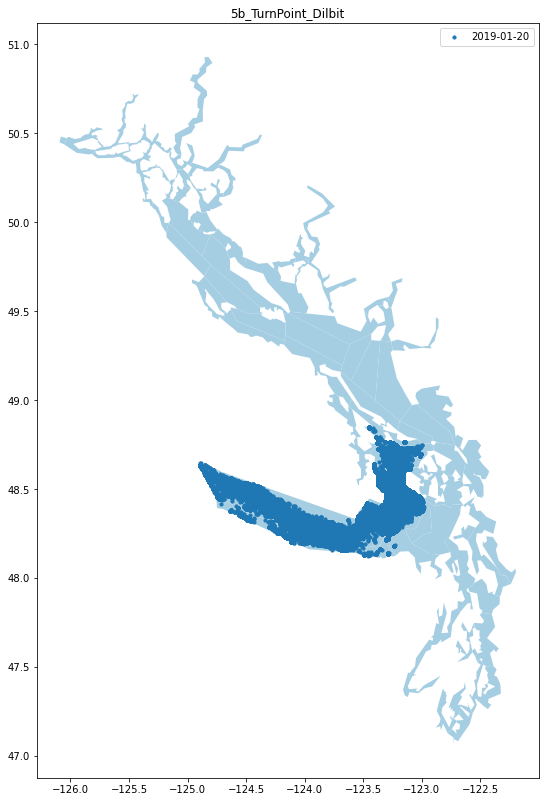

In [18]:
# Reading in the files generated by Ocean Parcels
_cmap = cm.Paired
land_df = data_df.loc[land_boxes]

ax = data_df.plot(figsize=(9, 15), column = 'vertmix', cmap=_cmap, 
    vmin=0, vmax = 10,
    legend=False,
    )
land_df.plot(ax=ax, color='white')
names = []

for path in scens:
    nm = str(path).split(sep = '_')
    names.append(nm[3])

    pfile = xr.open_zarr(str(path))
    #an array of times that correspond to Atlantis timesteps
    time_slice = np.arange(0,len(pfile.time[0]),12) #or any N
    reduced_pfile = pfile.isel(obs=(time_slice))

    lon = reduced_pfile.variables['lon']
    lat = reduced_pfile.variables['lat']

    if "-01-" in nm[3]:
        point_colour = '#1f77b4'
    elif "-04-" in nm[3]:
        point_colour = '#2ca02c'
    elif "-07-" in nm[3]:
        point_colour = '#fd8d3d'
    else:
        point_colour = '#8b564c'

    ax.scatter(lon, lat, s=10, zorder=20, c=point_colour) #s=0.001
ax.set_title(scenario[file_id], fontsize = 12)
ax.legend(names);

In [19]:
time_slice.size

20

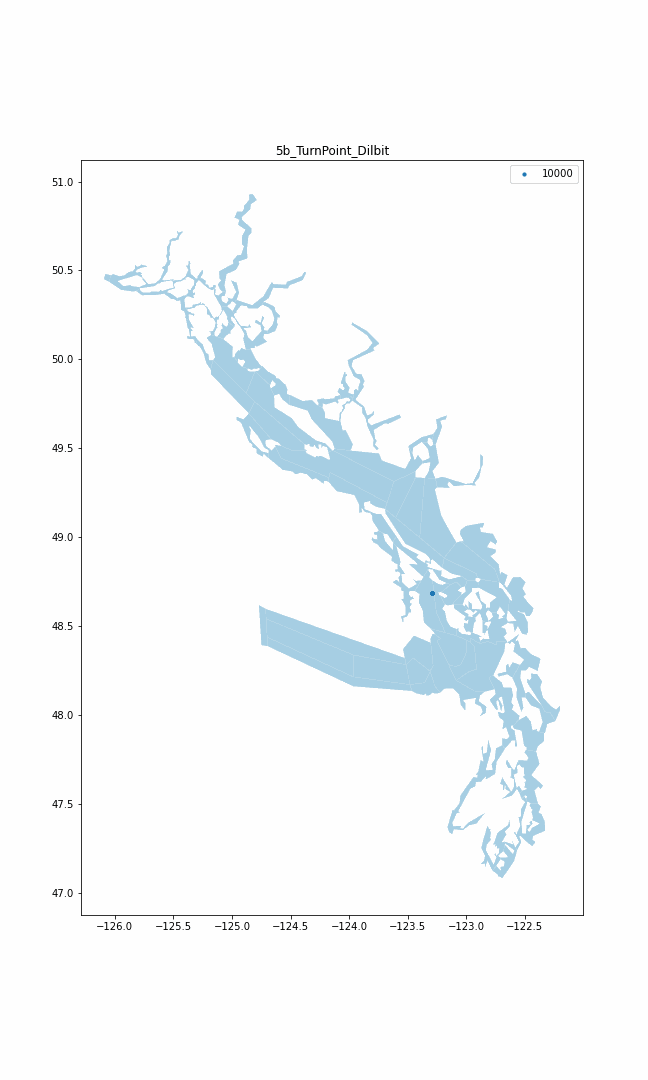

In [17]:
_cmap = cm.Paired
land_df = data_df.loc[land_boxes]

numObs = time_slice.size + 1
file_names = []

for time_index in range(0, numObs):

    fig = plt.figure(figsize=(9, 15), facecolor='white')
    ax = fig.add_subplot()
    data_df.plot(figsize=(9, 15), column = 'vertmix', cmap=_cmap, ax=ax,
        vmin=0, vmax = 10,
        legend=False,
        )
    land_df.plot(ax=ax, color='white')
    
    names = []

    for path in scens:
        nm = str(path).split(sep = '_')
        names.append(nm[3])

        pfile = xr.open_zarr(str(path))
        time_slice = np.arange(0,len(pfile.time[0]),12) #or any N
        reduced_pfile = pfile.isel(obs=(time_slice))

        lon = reduced_pfile.variables['lon']
        lat = reduced_pfile.variables['lat']

        plon = lon[:, time_index]
        plat = lat[:, time_index]

        ax.scatter(plon, plat, s=10, zorder=20) #s=0.001
    ax.set_title(scenario[file_id], fontsize = 12)
    ax.legend(names);

    #plt.tight_layout()
    plot_name = 'particles_at_time_' + str(time_index).zfill(3) + '.png'
    plt.savefig(plot_name)
    file_names.append(plot_name)
    plt.close()

# Create the frames
frames = []
imgs = glob.glob("particles_at_time*.png")
imgs.sort() 
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)


# Save into loop
anim_name = 'Particle_trajectory_' + str(scenario[file_id])+'.gif'
frames[0].save(anim_name, format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=300, loop=0)

file_name_str = ' '.join(file_names)
os.system('rm ' + file_name_str)

# Plot image
with open(anim_name,'rb') as anim:
    display(im(anim.read()))